## ProjF5 - Final Model

* **Please be advised that all models have been re-executed, and as a result, there may be slight variations in the outcomes compared to those presented in the slides.**

* **Our models are LSTM+CNN and BiLSTM+CNN**






In [1]:
#Importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Concatenate, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/Users/rajat/dev/demand-supply-forecasting/my_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 1. Load and Prepare Data

In [26]:
#Reading data as a DataFrame
data = pd.read_csv('/Users/rajat/dev/demand-supply-forecasting/data/train.csv')

In [27]:
data

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [28]:
#Checking for duplicate rows in the dataset
print("Duplicate rows:", data.duplicated().sum())

Duplicate rows: 0


In [29]:
# Converting 'date' attribute to date type
data['id'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


In [30]:
#Checking for null values in the dataset
data.isna().sum()

date     0
store    0
item     0
sales    0
id       0
dtype: int64

Since none of the attributes individually exhibit a strong correlation with sales, we have decided to include all attributes in the model. By considering them together, we aim to capture potential interactions and dependencies between the attributes, which can contribute to the effectiveness of the model during training.

In [31]:
'''Sorting the data according to date as it is a time-stamped dataset and it
would be convinient for traininig the models on sorted data'''

data = data.sort_values('date')

In [33]:
'''It can be seen that all the null values for sales are from 2018-01-01 to
2018-03-31 as the goal of the competition, from where this dataset is obtained,
is to predict the sales of the stores during this time period using historical
data'''

data[data['sales'].isna()]

,date,store,item,sales,id


In [34]:
#Storing the rows where sales need to be predicted in y (test set)
y = data[data['sales'].isna()]


In [35]:
y

,date,store,item,sales,id


In [36]:
data = data.drop(y.index)

In [37]:
data.isna().sum()

date     0
store    0
item     0
sales    0
id       0
dtype: int64

In [38]:
#Storing the rest of the data in X (train set)
X = data
X = X.reset_index(drop=True)

In [39]:
#Printing the train set
X

,date,store,item,sales,id
0,2013-01-01,1,1,13,2013-01-01
1,2013-01-01,7,12,26,2013-01-01
2,2013-01-01,7,46,27,2013-01-01
3,2013-01-01,8,12,54,2013-01-01
4,2013-01-01,9,12,35,2013-01-01
...,...,...,...,...,...
912995,2017-12-31,9,34,21,2017-12-31
912996,2017-12-31,10,34,32,2017-12-31
912997,2017-12-31,1,35,55,2017-12-31
912998,2017-12-31,8,33,100,2017-12-31


In [47]:
#Printing the test set
y = y.reset_index(drop=True)
y
print(X['date'].dtype)
X['date'] = pd.to_datetime(X['date'], errors='coerce')
print(X['date'].head())
print(X['date'].isna().sum())  # Count of NaT values
X = X.dropna(subset=['date'])
X['date'].fillna(pd.Timestamp('2000-01-01'), inplace=True)
X['year'] = X['date'].dt.year





datetime64[ns]
0   2013-01-01
1   2013-01-01
2   2013-01-01
3   2013-01-01
4   2013-01-01
Name: date, dtype: datetime64[ns]
0


/var/folders/kw/82xjb3pj3svd36j4g47p__280000gn/T/ipykernel_2113/1101727554.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['date'].fillna(pd.Timestamp('2000-01-01'), inplace=True)


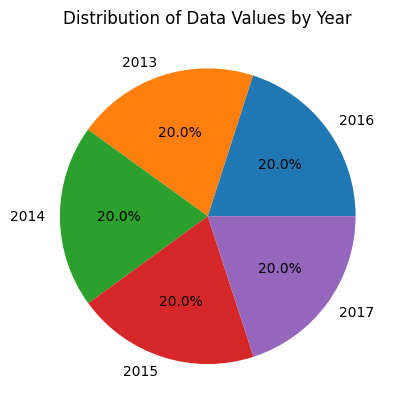

In [48]:
#Data distribution for each year in train set
X['year'] = X['date'].dt.year


year_counts = X['year'].value_counts()

plt.pie(year_counts, labels=year_counts.index, autopct='%1.1f%%')


plt.title('Distribution of Data Values by Year')


plt.show()


As we can see, we do not have any data imbalance in the train set. The data is distributed uniformly for each year.

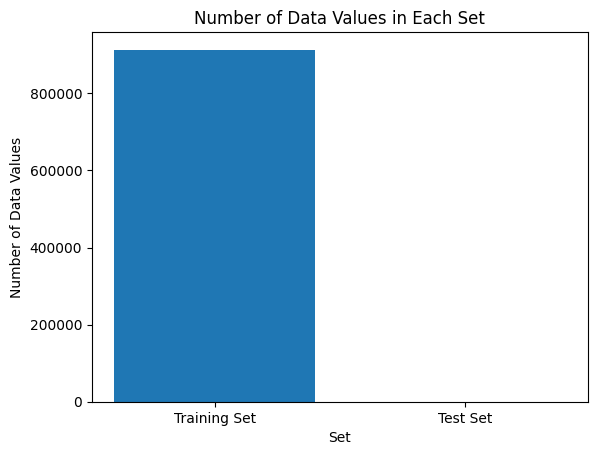

In [49]:
#Bar plot for showing the data distribution in train and test split

num_train = X.shape[0]
num_test = y.shape[0]

plt.bar(['Training Set', 'Test Set'], [num_train, num_test])

plt.title('Number of Data Values in Each Set')
plt.xlabel('Set')
plt.ylabel('Number of Data Values')

plt.show()


### 2. Preparing your Final Model

#BiLSTM

In [53]:
X_bilstm = X

In [57]:
X_bilstm

,date,store,item,sales,id,year
0,2013-01-01,1,1,13,2013-01-01,2013
1,2013-01-01,7,12,26,2013-01-01,2013
2,2013-01-01,7,46,27,2013-01-01,2013
3,2013-01-01,8,12,54,2013-01-01,2013
4,2013-01-01,9,12,35,2013-01-01,2013
...,...,...,...,...,...,...
912995,2017-12-31,9,34,21,2017-12-31,2017
912996,2017-12-31,10,34,32,2017-12-31,2017
912997,2017-12-31,1,35,55,2017-12-31,2017
912998,2017-12-31,8,33,100,2017-12-31,2017


In [58]:
# Converting 'date' column to ordinal to use it as a feature
X_bilstm['date'] = X_bilstm['date'].apply(lambda x: x.toordinal())

In [59]:
X_bilstm

,date,store,item,sales,id,year
0,734869,1,1,13,2013-01-01,2013
1,734869,7,12,26,2013-01-01,2013
2,734869,7,46,27,2013-01-01,2013
3,734869,8,12,54,2013-01-01,2013
4,734869,9,12,35,2013-01-01,2013
...,...,...,...,...,...,...
912995,736694,9,34,21,2017-12-31,2017
912996,736694,10,34,32,2017-12-31,2017
912997,736694,1,35,55,2017-12-31,2017
912998,736694,8,33,100,2017-12-31,2017


In [60]:
# Dropping 'year' column as it is redundant
X_bilstm.drop(columns=['year'], inplace=True)

In [61]:
# Feature scaling
scaler = MinMaxScaler()
X_bilstm[['date', 'store', 'item']] = scaler.fit_transform(X_bilstm[['date', 'store', 'item']])
y = scaler.fit_transform(X_bilstm[['sales']])

In [62]:
# Defining function to create sequences
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [63]:
# Creating sequences for BiLSTM model
X_seq, y_seq = create_sequences(X_bilstm[['date', 'store', 'item']].values, y)

# Splitting the dataset into train and test sets
X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [64]:
#Using the same number of BiLSTM units as LSTM used in Baseline report for fair comparision

bilstm_model = Sequential([
    Bidirectional(LSTM(units=50, activation='relu'), input_shape=(X_train_bilstm.shape[1], X_train_bilstm.shape[2])),
    Dense(units=1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

/Users/rajat/dev/demand-supply-forecasting/my_env/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
# Training the model (using the same epoch and batch size as Baseline for fair comparision)
bilstm_model.fit(X_train_bilstm, y_train_bilstm, epochs=1, batch_size=32, validation_split=0.1)

20543/20543 ━━━━━━━━━━━━━━━━━━━━ 19s 910us/step - loss: 0.0143 - val_loss: 0.0142


In [67]:
from tensorflow.keras.models import load_model
# Save the model
bilstm_model.save("bilstm_model.h5")


In [76]:
bisltm_model = load_model('/Users/rajat/dev/demand-supply-forecasting/src/bilstm_model.h5')

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [ ]:
# Evaluating the model
test_loss_bilstm = bisltm_model.evaluate(X_test_bilstm, y_test_bilstm)
print("Test Loss:", test_loss_bilstm)

#LSTM+CNN (Our Model)

In [21]:
X_hyb = X

In [22]:
# Converting 'date' column to ordinal to use it as a feature
X_hyb['date'] = X_hyb['date'].apply(lambda x: x.toordinal())

In [23]:
# Dropping 'year' column as it is redundant
X_hyb.drop(columns=['year'], inplace=True)

In [24]:
# # One-hot encode 'store' column
# one_hot_encoded = pd.get_dummies(X_hyb['store'], prefix='store')

# # Convert True/False to 1/0
# one_hot_encoded = one_hot_encoded.astype(int)

# # Concatenate one-hot encoded columns to the original DataFrame
# X_hyb = pd.concat([X_hyb.drop('store', axis=1), one_hot_encoded], axis=1)

In [ ]:
X_hyb

In [26]:
# Feature scaling
scaler = MinMaxScaler()
X_hyb.loc[:, X_hyb.columns != 'sales'] = scaler.fit_transform(X_hyb.loc[:, X_hyb.columns != 'sales'])
y = scaler.fit_transform(X_hyb[['sales']])

In [27]:
# Defining function to create sequences
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [28]:
# Creating sequences for LSTM+CNN model
X_seq, y_seq = create_sequences(X_hyb[['date', 'store', 'item']].values, y)

# Splitting the dataset into train and test sets
X_train_hyb, X_test_hyb, y_train_hyb, y_test_hyb = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
y_train_hyb

In [ ]:
# Define input layers for LSTM and CNN models
lstm_input = Input(shape=(X_train_hyb.shape[1], X_train_hyb.shape[2]))
cnn_input = Input(shape=(X_train_hyb.shape[1], X_train_hyb.shape[2]))

# LSTM model
lstm_output = LSTM(units=50, activation='relu')(lstm_input)

# CNN model
cnn_output = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_output = MaxPooling1D(pool_size=2)(cnn_output)
cnn_output = Flatten()(cnn_output)

# Concatenate the outputs of LSTM and CNN models
concatenated = Concatenate()([lstm_output, cnn_output])

# Combine with dense layers
combined = Dense(64, activation='relu')(concatenated)
output = Dense(1)(combined)

# Define the ensemble model
ensemble_model = Model(inputs=[lstm_input, cnn_input], outputs=output)

# Compile the model
ensemble_model.compile(optimizer='adam', loss='mse')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("ensemble_model_checkpoint.h5", monitor='val_loss', save_best_only=True)

# Train the model
history = ensemble_model.fit([X_train_hyb, X_train_hyb], y_train_hyb, epochs=50, batch_size=256, validation_data=([X_test_hyb, X_test_hyb], y_test_hyb), callbacks=[early_stopping, checkpoint])



In [31]:
# # Load the best model from checkpoint
# from tensorflow.keras.models import load_model
# hyb_model = load_model("ensemble_model_checkpoint.h5")
# hyb_model.save("ensemble_model.h5")


In [ ]:
# Evaluate the model on the test set
test_loss_ensemble = ensemble_model.evaluate([X_test_hyb, X_test_hyb], y_test_hyb)

print("Test Loss:", test_loss_ensemble)


#BiLSTM+CNN (Our Model)

In [52]:
X_bcnn = X

In [ ]:
X_bcnn

In [54]:
# Converting 'date' column to ordinal to use it as a feature
X_bcnn['date'] = X_bcnn['date'].apply(lambda x: x.toordinal())

In [55]:
# Dropping 'year' column as it is redundant
X_bcnn.drop(columns=['year'], inplace=True)

In [56]:
# X_encoded = pd.get_dummies(X_gru, columns=['store', 'item'], dtype=int)

# # Drop the original 'date' column if you don't need it
# X_encoded.drop(columns=['date'], inplace=True)

In [ ]:
X_bcnn

In [58]:
# Feature scaling
scaler = MinMaxScaler()

X_scaled = X_bcnn.iloc[:, :-1]

X_scaled.iloc[:, :] = scaler.fit_transform(X_scaled)

X_bcnn.iloc[:, :-1] = X_scaled
y = scaler.fit_transform(X_bcnn[['sales']])

In [ ]:
X_bcnn

In [60]:
# Defining function to create sequences
def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [61]:
# Creating sequences for GRU+CNN model
X_seq, y_seq = create_sequences(X_bcnn.drop(columns=['sales']).values, y)

# Splitting the dataset into train and test sets
X_train_bcnn, X_test_bcnn, y_train_bcnn, y_test_bcnn = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
# Define input layers for BiLSTM and CNN models
bilstm_input = Input(shape=(X_train_bcnn.shape[1], X_train_bcnn.shape[2]))
cnn_input = Input(shape=(X_train_bcnn.shape[1], X_train_bcnn.shape[2]))

# BiLSTM model
lstm_layer = LSTM(units=50, activation='relu')
bilstm_output = Bidirectional(lstm_layer)(bilstm_input)

# CNN model
cnn_output = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_output = MaxPooling1D(pool_size=2)(cnn_output)
cnn_output = Flatten()(cnn_output)

# Concatenate the outputs of BiLSTM and CNN models
concatenated = Concatenate()([bilstm_output, cnn_output])

# Combine with dense layers
combined = Dense(64, activation='relu')(concatenated)
output = Dense(1)(combined)

# Define the ensemble model
ensemble_model_blstm = Model(inputs=[bilstm_input, cnn_input], outputs=output)

# Compile the model
ensemble_model_blstm.compile(optimizer='adam', loss='mse')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("ensemble_model__blstm_checkpoint.h5", monitor='val_loss', save_best_only=True)

# Train the model
history = ensemble_model_blstm.fit([X_train_hyb, X_train_hyb], y_train_hyb, epochs=50, batch_size=256, validation_data=([X_test_bcnn, X_test_bcnn], y_test_hyb), callbacks=[early_stopping, checkpoint])


In [ ]:
# Evaluate the model on the test set
test_loss_bilstm = ensemble_model_blstm.evaluate([X_test_bcnn, X_test_bcnn], y_test_bcnn)

print("Test Loss:", test_loss_bilstm)


### 3. Model Performance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['BiLSTM', 'LSTM+CNN', 'BiLSTM+CNN']

# Train MSE values
train_mse = [0.01354, 0.01352, 0.01349]

# Test MSE values
test_mse = [0.013483, 0.013461, 0.013482]

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))

bars1 = plt.bar(index, train_mse, bar_width, color='blue', label='Train MSE')
bars2 = plt.bar(index + bar_width, test_mse, bar_width, color='orange', label='Test MSE')

plt.yscale('log')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Train and Test MSE for Different Models')
plt.legend()
plt.xticks(index + bar_width / 2, models, rotation=45)

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 6), va='bottom', ha='center')

plt.tight_layout()
plt.show()


# BiLSTM+CNN results

In [51]:
predicted_values = ensemble_model_blstm.predict([X_test_bcnn, X_test_bcnn])
predicted_values_inverse = scaler.inverse_transform(predicted_values)

y_test_bcnn_inverse = scaler.inverse_transform(y_test_bcnn)

results_df = pd.DataFrame({'Predicted': predicted_values_inverse.flatten(), 'Actual': y_test_bcnn_inverse.flatten()})

print(results_df)

NameError: name 'ensemble_model_blstm' is not defined

# LSTM+CNN results

In [50]:
predicted_values = ensemble_model.predict([X_test_hyb, X_test_hyb])
predicted_values_inverse = scaler.inverse_transform(predicted_values)

y_test_inverse = scaler.inverse_transform(y_test_hyb)


results_df = pd.DataFrame({'Predicted': predicted_values_inverse.flatten(), 'Actual': y_test_inverse.flatten()})

print(results_df)

NameError: name 'ensemble_model' is not defined